In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from numpy import pi, sqrt

# Matplotlib configuration
plt.style.use(['science', 'grid'])
plt.rcParams.update({'font.size': 18, 'text.usetex': True})

In [2]:
# Load CVDV library (reload if already loaded)
import sys
import importlib
if 'interface' in sys.modules:
    importlib.reload(sys.modules['interface'])
from interface import CVDV

-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/luxi/cuda-cvdv/build
[100%] Built target cvdv
Build successful: /home/luxi/cuda-cvdv/build/libcvdv.so

Library compiled successfully!
Library loaded successfully!
Debug logs are written to: /home/luxi/cuda-cvdv/cuda.log
NOTE: Log file is cleared each time CVDV() is instantiated


---
# Part 1: Single Register Tests

Test operations on a single register with large dimension.

In [3]:
# Simulation parameters for single register tests
CV_LEVEL = 12      # 2^12 = 4096 grid points
WIGNER_N = 201     # Wigner function grid size
WIGNER_MAX = 5.0   # Wigner function range
PLOT_X_RANGE = 6   # x-axis range for plots

## Test 1: Vacuum State

Number of registers: 1
Total state size: 4096
  Register 0: dim=4096, qubits=12, dx=0.039166, x_bound=160.424210
Initialized state with 1 registers, total size: 4096


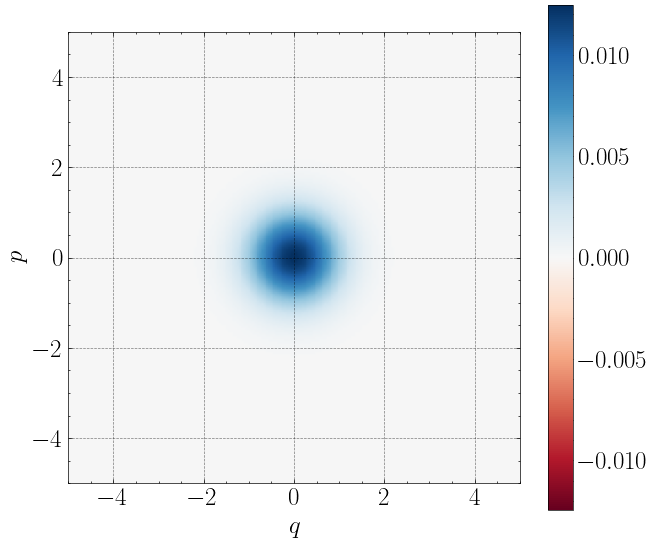

In [4]:
# Initialize single register system
# Register with 2^12 = 4096 points, dx automatically calculated
sim = CVDV([CV_LEVEL])

# Initialize to vacuum state
sim.setFock(0, 0)
sim.initStateVector()  # Build tensor product and upload to device

# Print system info
sim.info()

def debugPlot():
    wigner_complex = sim.getWignerSingleSlice(0, [ -1 ], wignerN=WIGNER_N, wXMax=WIGNER_MAX, wPMax=WIGNER_MAX)

    fig, ax = plt.subplots(figsize=(7, 6))
    vmax = np.max(np.abs(wigner_complex))
    im = ax.imshow(wigner_complex, extent=[-WIGNER_MAX, WIGNER_MAX, -WIGNER_MAX, WIGNER_MAX],
                origin='lower', cmap='RdBu', vmin=-vmax, vmax=vmax, aspect='equal')
    ax.set_xlabel(r'$q$')
    ax.set_ylabel(r'$p$')
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()
    
debugPlot()

## Test 2: Displacement Operator

Test D(α) with different displacement parameters.

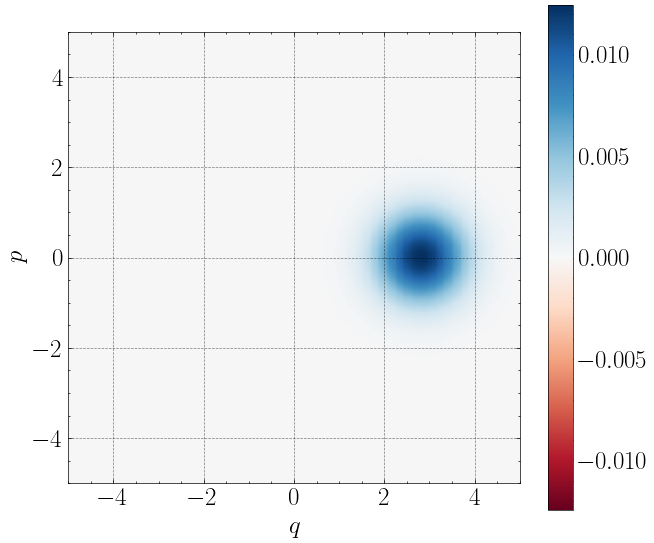

In [5]:
# Test with real displacement
sim.setFock(0, 0)  # Reset to vacuum
sim.displacement(0, 2)
debugPlot()

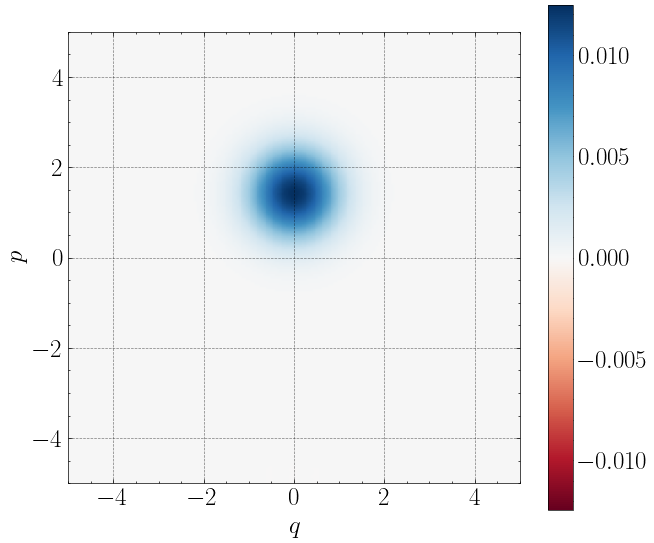

In [6]:
# Test with complex displacement
sim.displacement(0, -2 + 1.0j)
debugPlot()

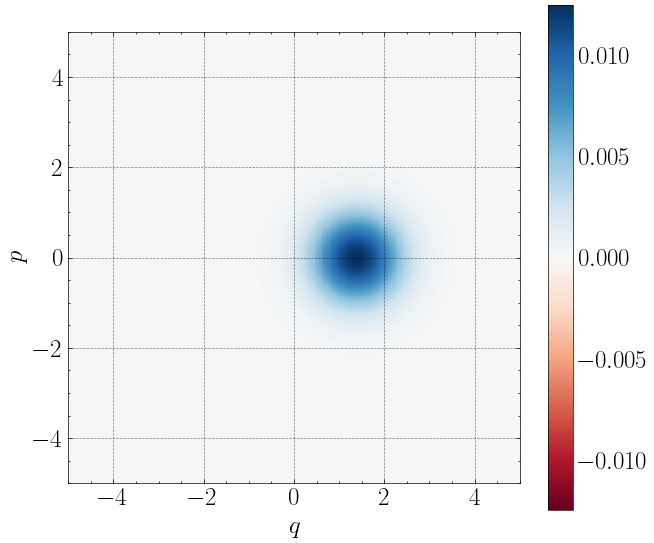

In [7]:
sim.ftQ2P(0)  # Fourier transform to momentum basis
debugPlot()

---
# Part 2: Multi-Register Tests

Test conditional displacement with 2 registers of different dimensions.

In [8]:
# Free the simulator resources and reload library
del sim

DV_QUBITS = 1
CV_LEVEL_HYBRID = 10
sim = CVDV([DV_QUBITS, CV_LEVEL_HYBRID])

# Initialize: |0⟩ ⊗ |vac⟩
sim.setZero(0)  # Register 0 to |0⟩
sim.setFock(1, 0)  # Register 1 to vacuum
sim.initStateVector()  # Build tensor product and upload to device

sim.info()
def debugPlot():
    # Compute Wigner functions for each qubit basis state
    # For register 1 when register 0 is in |0⟩ or |1⟩
    wigner_0 = sim.getWignerSingleSlice(1, [0, -1], wignerN=WIGNER_N, 
                                        wXMax=WIGNER_MAX, wPMax=WIGNER_MAX)
    wigner_1 = sim.getWignerSingleSlice(1, [1, -1], wignerN=WIGNER_N,
                                        wXMax=WIGNER_MAX, wPMax=WIGNER_MAX)

    # Verify probabilities using new API
    probs = sim.measure(0)
    print(f"Register 0 probabilities: {probs}")
    print(f"P(qubit=|0⟩) = {probs[0]:.6f}")
    print(f"P(qubit=|1⟩) = {probs[1]:.6f}")
    print(f"Sum = {probs.sum():.6f} (should be 1.0)")

    # Plot both Wigner functions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # |0⟩ component (displaced by +α)
    vmax = np.max(np.abs(wigner_0))
    im1 = ax1.imshow(wigner_0, extent=[-WIGNER_MAX, WIGNER_MAX, -WIGNER_MAX, WIGNER_MAX],
                    origin='lower', cmap='RdBu', vmin=-vmax, vmax=vmax, aspect='equal')
    ax1.set_xlabel(r'$q$')
    ax1.set_ylabel(r'$p$')
    ax1.set_title(r'$|0\rangle \otimes ?$')
    plt.colorbar(im1, ax=ax1)

    # |1⟩ component (displaced by -α)
    vmax = np.max(np.abs(wigner_1))
    im2 = ax2.imshow(wigner_1, extent=[-WIGNER_MAX, WIGNER_MAX, -WIGNER_MAX, WIGNER_MAX],
                    origin='lower', cmap='RdBu', vmin=-vmax, vmax=vmax, aspect='equal')
    ax2.set_xlabel(r'$q$')
    ax2.set_ylabel(r'$p$')
    ax2.set_title(r'$|1\rangle \otimes ?$')
    plt.colorbar(im2, ax=ax2)

    plt.tight_layout()
    plt.show()


Number of registers: 2Initialized state with 2 registers, total size: 2048

Total state size: 2048
  Register 0: dim=2, qubits=1, dx=1.772454, x_bound=3.544908
  Register 1: dim=1024, qubits=10, dx=0.078332, x_bound=80.212105


## Test: Conditional Displacement CD(α)

Prepare |+⟩ ⊗ |vac⟩ and apply CD(α):
- CD(α)|+⟩|vac⟩ = (|0⟩|+α⟩ + |1⟩|-α⟩)/√2

Register 0 probabilities: [0.5 0.5]
P(qubit=|0⟩) = 0.500000
P(qubit=|1⟩) = 0.500000
Sum = 1.000000 (should be 1.0)


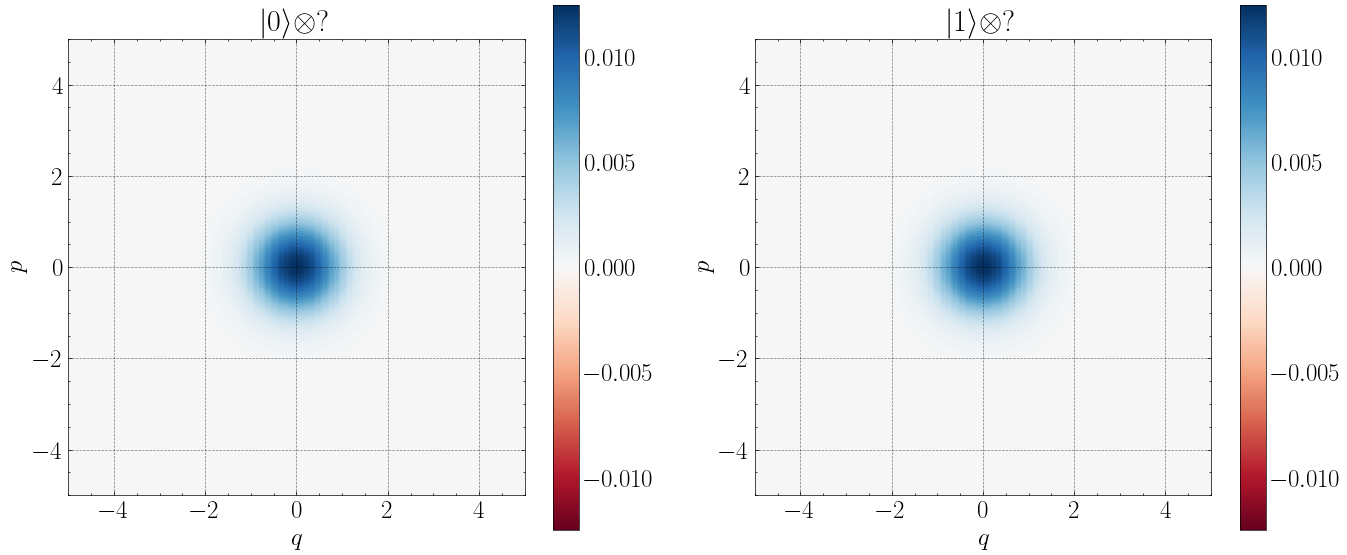

In [9]:
# Prepare |+⟩ = (|0⟩ + |1⟩)/√2
sim.hadamard(0, 0)  # Hadamard on qubit 0 of register 0
debugPlot()

Register 0 probabilities: [0.5 0.5]
P(qubit=|0⟩) = 0.500000
P(qubit=|1⟩) = 0.500000
Sum = 1.000000 (should be 1.0)


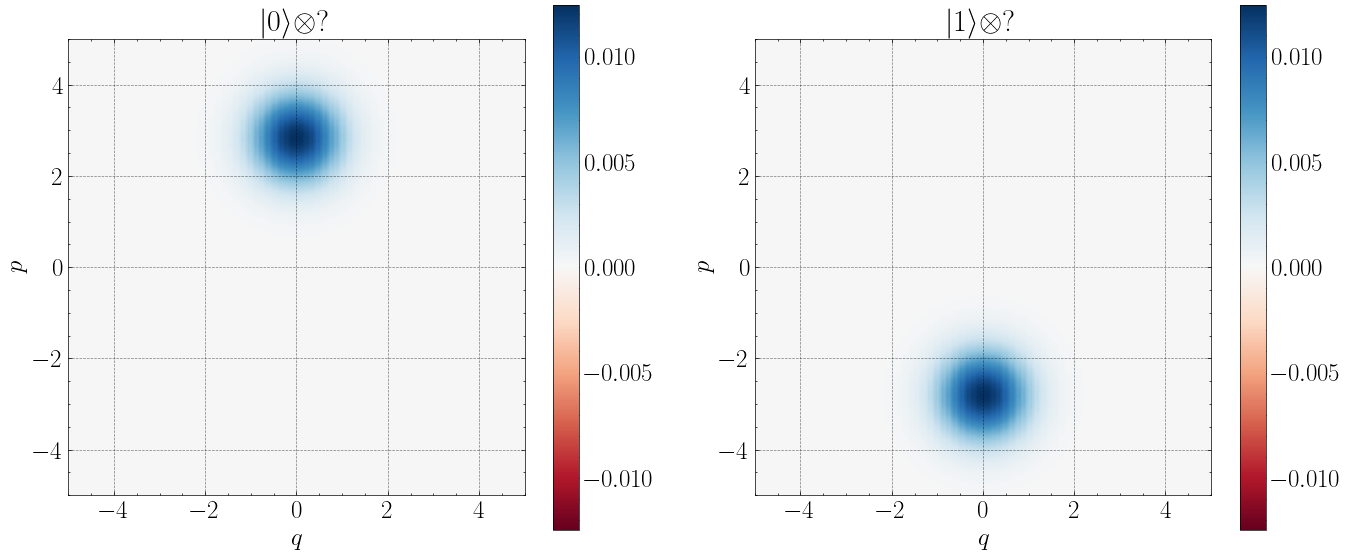

In [10]:
# Apply conditional displacement
alpha_cd = 2.0j
sim.cd(targetReg=1, ctrlReg=0, ctrlQubit=0, alpha=alpha_cd)
debugPlot()

Register 0 probabilities: [0.5 0.5]
P(qubit=|0⟩) = 0.500000
P(qubit=|1⟩) = 0.500000
Sum = 1.000000 (should be 1.0)


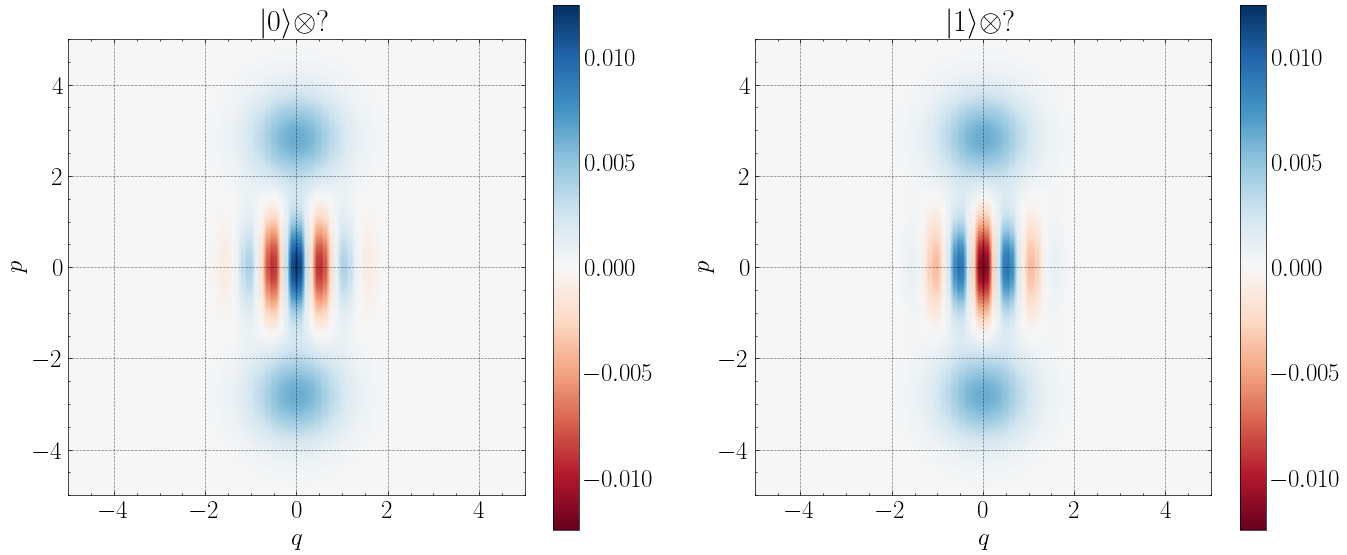

In [11]:
# Apply Hadamard again to complete entangling operation
sim.hadamard(0, 0)
debugPlot()

Register 0 probabilities: [0.5 0.5]
P(qubit=|0⟩) = 0.500000
P(qubit=|1⟩) = 0.500000
Sum = 1.000000 (should be 1.0)


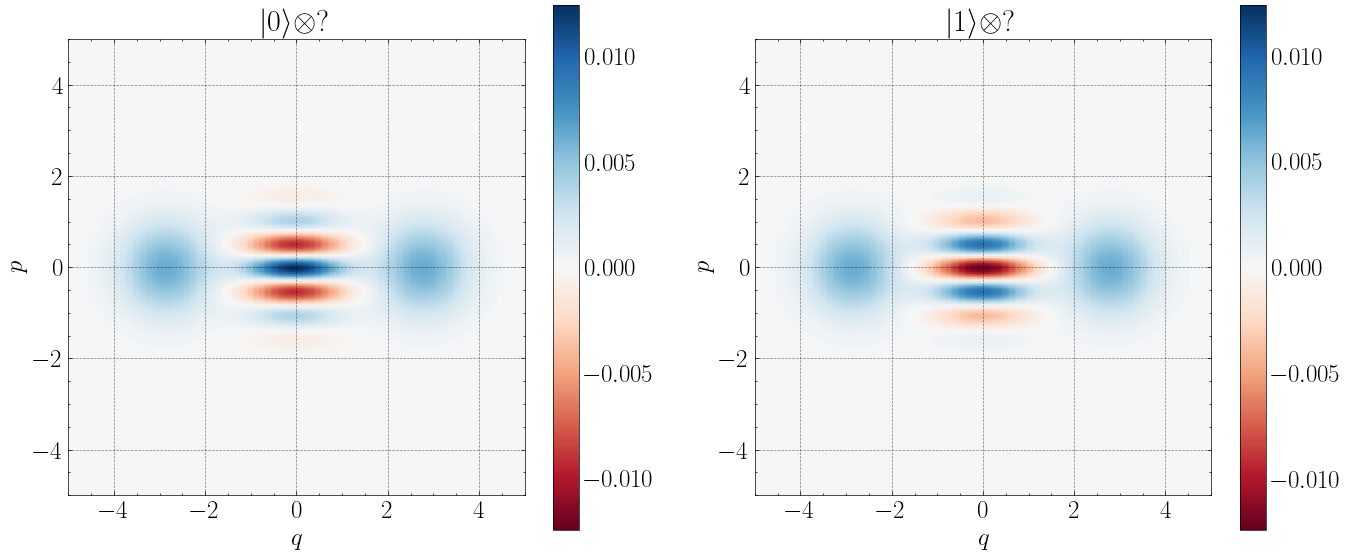

Register 0 probabilities: [0.5 0.5]
P(qubit=|0⟩) = 0.500000
P(qubit=|1⟩) = 0.500000
Sum = 1.000000 (should be 1.0)


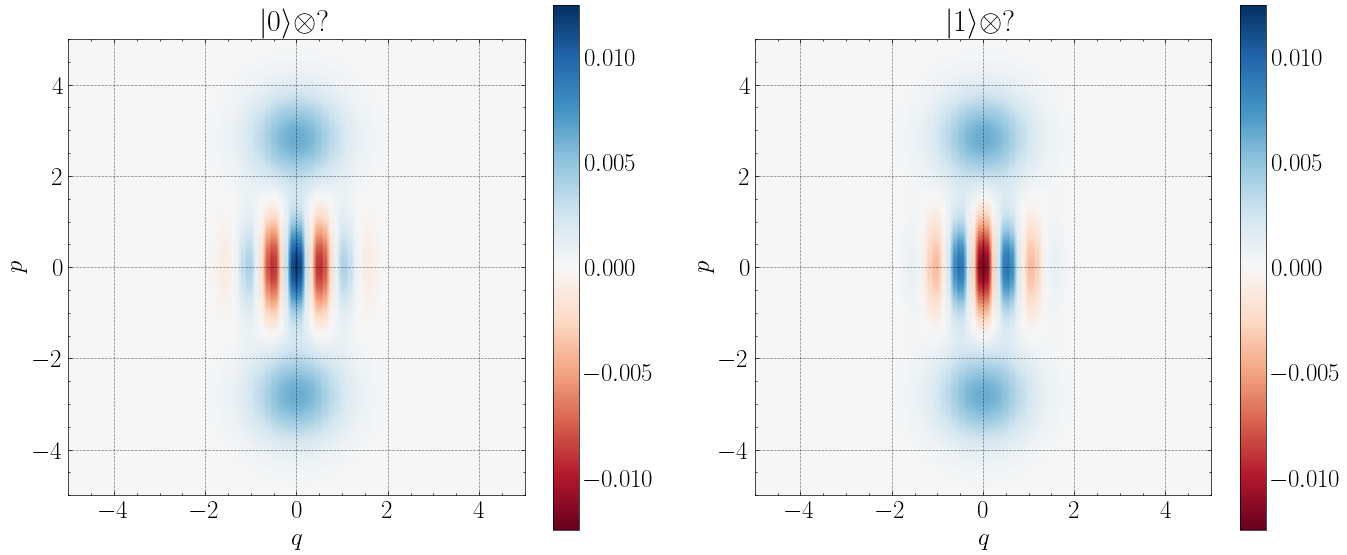

In [12]:
# Test Fourier Transform
sim.ftQ2P(1)
debugPlot()
sim.ftP2Q(1)
debugPlot()

In [13]:
# # Testing phase square gate
# sim.phaseSquare(1, 0.5)
# debugPlot()

Register 0 probabilities: [0.5 0.5]
P(qubit=|0⟩) = 0.500000
P(qubit=|1⟩) = 0.500000
Sum = 1.000000 (should be 1.0)


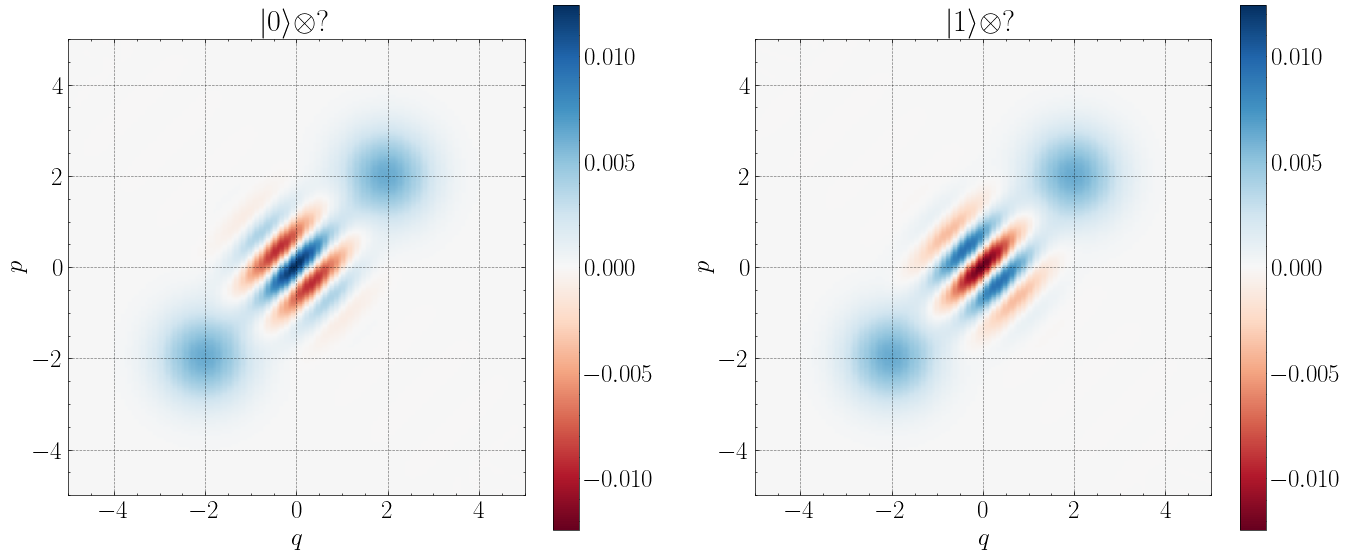

Register 0 probabilities: [0.5 0.5]
P(qubit=|0⟩) = 0.500000
P(qubit=|1⟩) = 0.500000
Sum = 1.000000 (should be 1.0)


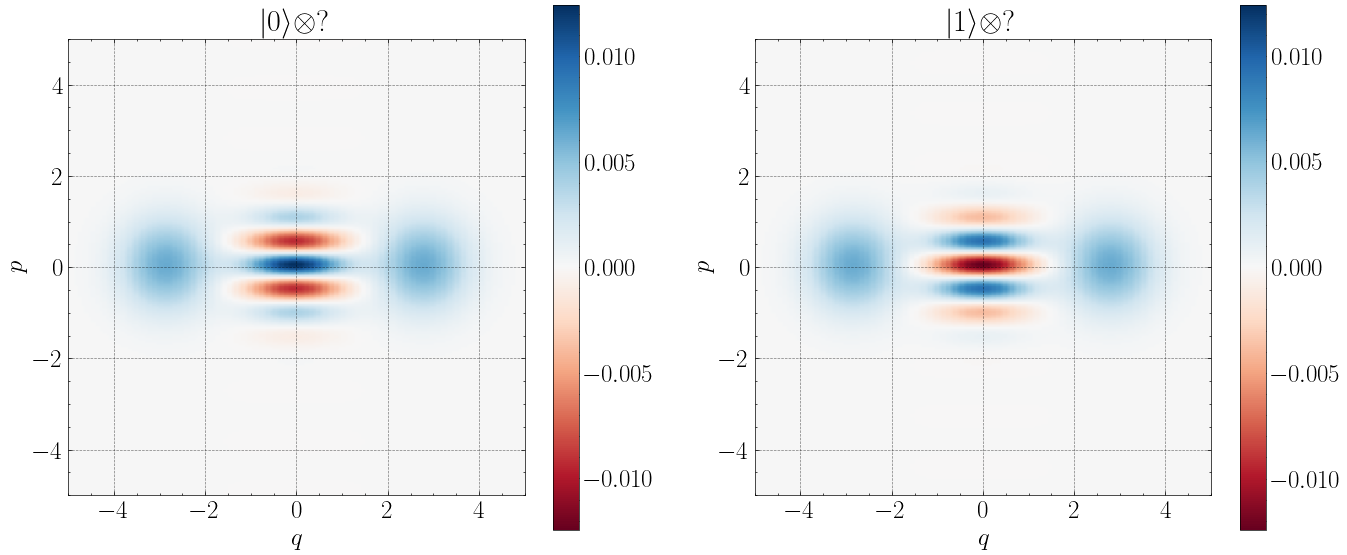

In [14]:
# Test Rotation Gate
sim.rotation(1, pi/4)
debugPlot()
sim.rotation(1, pi/4)
debugPlot()

Register 0 probabilities: [0.5 0.5]
P(qubit=|0⟩) = 0.500000
P(qubit=|1⟩) = 0.500000
Sum = 1.000000 (should be 1.0)


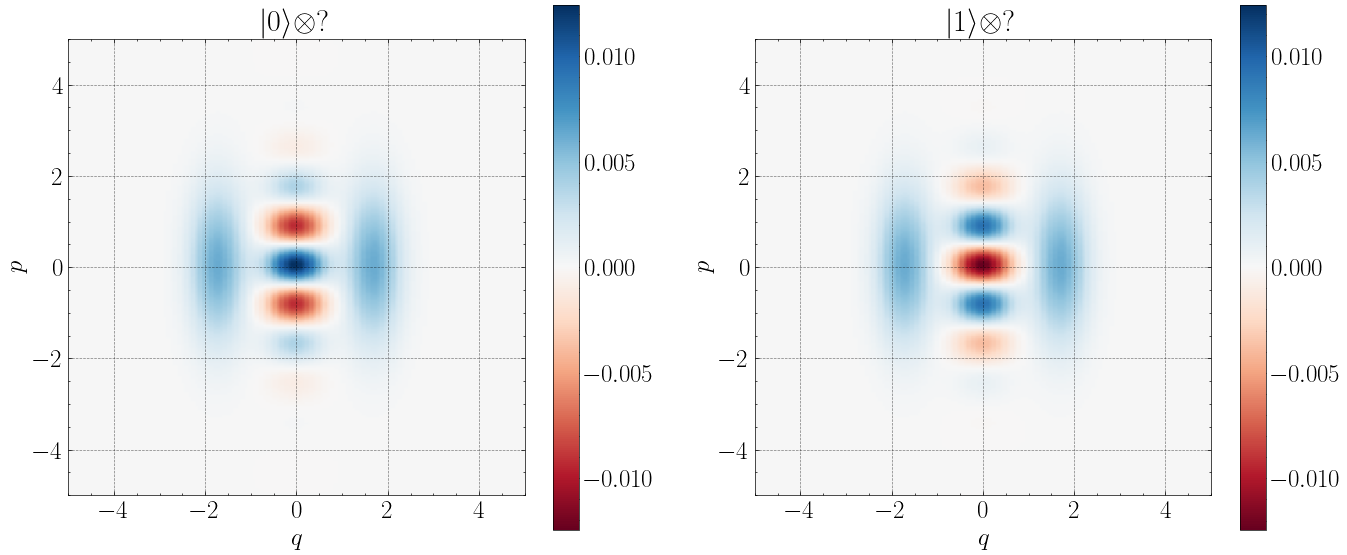

Register 0 probabilities: [0.5 0.5]
P(qubit=|0⟩) = 0.500000
P(qubit=|1⟩) = 0.500000
Sum = 1.000000 (should be 1.0)


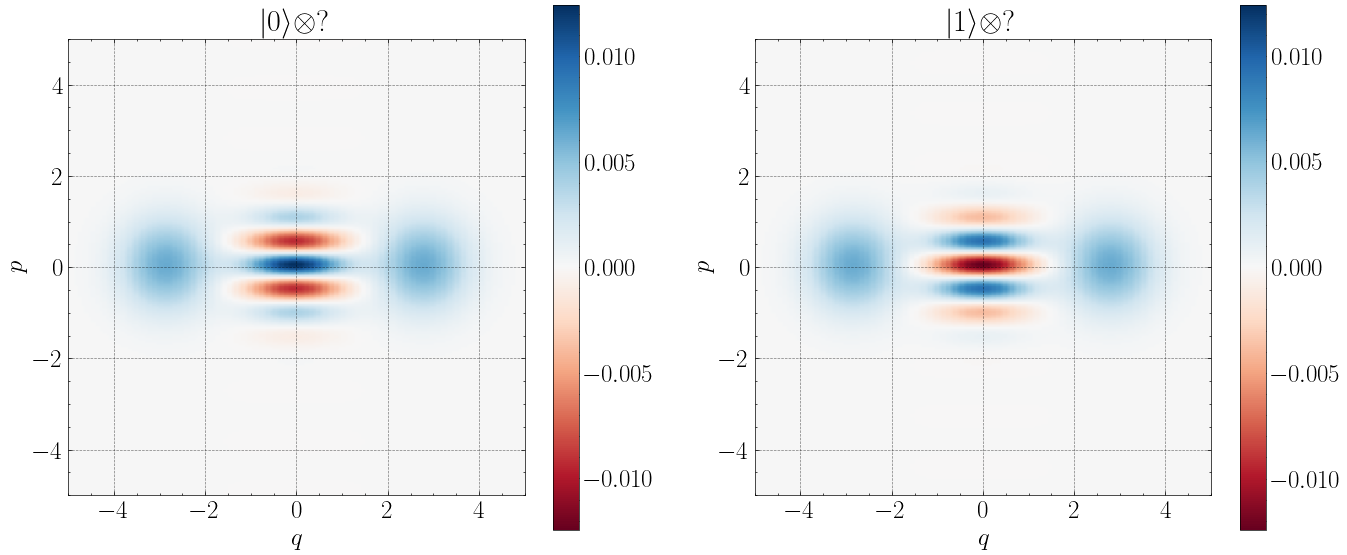

In [15]:
# Test Squeezing Gate
sim.squeezing(1, -0.5)
debugPlot()
sim.squeezing(1, 0.5)
debugPlot()